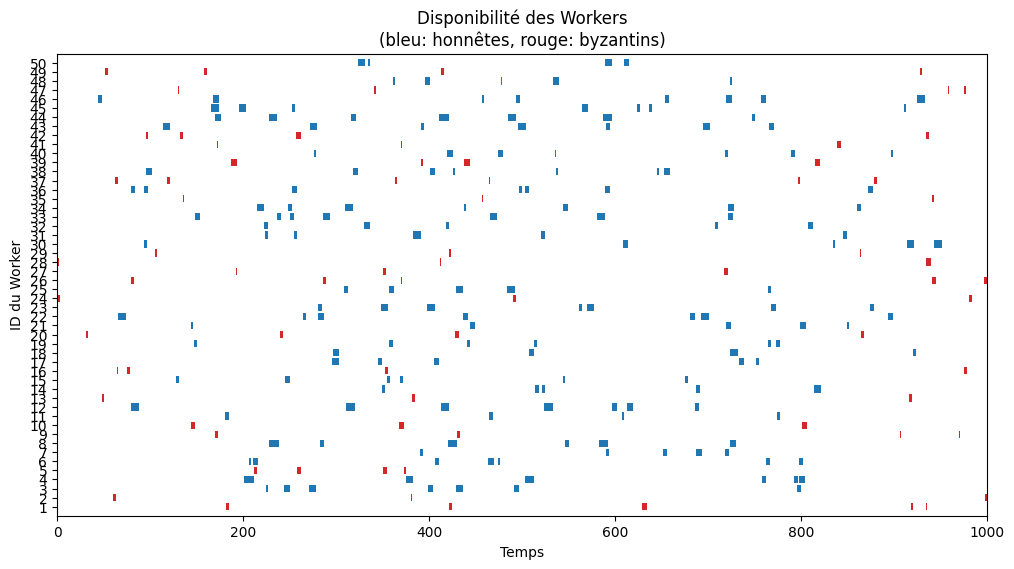

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt
import byzfl

# ------------------------------------------------------------------------------
# Fusionne les intervalles qui se chevauchent ou sont adjacents.
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged

# # Fonction de génération d'intervalles pour les workers honnêtes
# def generate_dynamic_availability(total_time_steps, worker_id, num_workers, max_periods=5, min_processing_time=2):
#     center = total_time_steps / 2
#     max_offset = total_time_steps / 8
#     if num_workers % 2 == 1:
#         mid = (num_workers + 1) / 2
#         offset = ((worker_id - mid) / mid) * max_offset
#     else:
#         mid = num_workers / 2
#         offset = ((worker_id - mid - 0.5) / mid) * max_offset
#     base_mean = center + offset
#     mean = int(np.clip(base_mean + random.randint(-total_time_steps // 20, total_time_steps // 20), 0, total_time_steps - min_processing_time))
#     std_dev = total_time_steps / 6
#     availability_periods = []
#     num_periods = random.randint(1, max_periods)
#     for _ in range(num_periods):
#         start_time = int(np.clip(np.random.normal(mean, std_dev), 0, total_time_steps - min_processing_time))
#         duration = max(min_processing_time, int(np.abs(np.random.normal(3, 2))))
#         end_time = min(start_time + duration, total_time_steps)
#         if end_time - start_time >= min_processing_time:
#             availability_periods.append((start_time, end_time))
#     return merge_intervals(availability_periods)

# # Fonction de génération de la disponibilité pour les workers byzantins
# def generate_byzantine_availability(total_time_steps, worker_id, num_workers, max_periods=5, min_processing_time=2):
#     if random.random() < 0.5:
#         mean = int(total_time_steps * random.uniform(0.0, 0.25))
#     else:
#         mean = int(total_time_steps * random.uniform(0.75, 1.0))
#     std_dev = total_time_steps / 10
#     availability_periods = []
#     num_periods = random.randint(1, max_periods)
#     for _ in range(num_periods):
#         start_time = int(np.clip(np.random.normal(mean, std_dev), 0, total_time_steps - min_processing_time))
#         duration = max(min_processing_time, int(np.abs(np.random.normal(3, 2))))
#         end_time = min(start_time + duration, total_time_steps)
#         if end_time - start_time >= min_processing_time:
#             availability_periods.append((start_time, end_time))
#     return merge_intervals(availability_periods)



import random
import numpy as np

def merge_intervals(intervals):
    # Fusionne les intervalles qui se chevauchent
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged


def generate_gaussian_availability(total_time_steps, worker_id, num_workers, std_dev_ratio=0.1, min_processing_time=3):
    """
    Disponibilité honnête : 3 pics durant les heures pleines.
    """
    # Trois pics bien définis (matin, après-midi, soir)
    peak_means = [0.25, 0.5, 0.75]  # en proportion du total
    std_dev = int(std_dev_ratio * total_time_steps)

    availability_periods = []

    for mean_ratio in peak_means:
        mean = int(mean_ratio * total_time_steps)
        intensity = random.choice([1, 2, 3])  # intensité aléatoire
        for _ in range(intensity):
            start_time = int(np.random.normal(loc=mean, scale=std_dev))
            start_time = max(0, min(start_time, total_time_steps - min_processing_time))
            max_extra = 2 * intensity
            duration = random.randint(min_processing_time, min(min_processing_time + max_extra, total_time_steps - start_time))
            end_time = start_time + duration
            availability_periods.append((start_time, end_time))

    return merge_intervals(availability_periods)




def generate_gaussian_byzantine_availability(total_time_steps, worker_id, num_workers, std_dev_ratio=0.08, min_processing_time=2):
    """
    Disponibilité byzantine : pics dans les heures creuses uniquement.
    """
    # Heures creuses : nuit/tôt le matin ou entre les pics honnêtes
    off_peak_means = [0.1, 0.375, 0.9]  # en proportion
    std_dev = int(std_dev_ratio * total_time_steps)

    availability_periods = []

    for mean_ratio in off_peak_means:
        mean = int(mean_ratio * total_time_steps)
        intensity = random.choice([1, 1, 2])  # faible à moyenne
        for _ in range(intensity):
            start_time = int(np.random.normal(loc=mean, scale=std_dev))
            start_time = max(0, min(start_time, total_time_steps - min_processing_time))
            max_extra = 1 * intensity
            duration = random.randint(1, min(min_processing_time + max_extra, total_time_steps - start_time))
            end_time = start_time + duration
            availability_periods.append((start_time, end_time))

    return merge_intervals(availability_periods)


# ------------------------------------------------------------------------------
# Définition du modèle de réseau de neurones
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ------------------------------------------------------------------------------
# Gestionnaire de batch complet avec SubsetRandomSampler
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.sampler = SubsetRandomSampler(self.indices)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            random.shuffle(self.indices)
            self.sampler = SubsetRandomSampler(self.indices)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Worker adapté pour traiter un mini-batch identifié par (complete_batch_id, mini_batch_id)
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_info = None  # (complete_batch_id, mini_batch_id)
    def is_available(self, current_time):
        for start_time, end_time in self.availability_periods:
            if start_time <= current_time < end_time:
                if self.finish_time is None or current_time >= self.finish_time:
                    return (current_time + self.processing_time) <= end_time
        return False
    def start_computation(self, current_time, batch_info, data, targets):
        if self.current_batch_info is None or self.current_batch_info != batch_info:
            self.current_batch_info = batch_info
            self.finish_time = current_time + self.processing_time
            return self.compute_gradient(data, targets)
        return None
    def has_finished(self, current_time):
        return self.finish_time == current_time
    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_info
    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)

# ------------------------------------------------------------------------------
# Worker byzantin qui renvoie un gradient corrompu
class ByzantineWorker(Worker):
    def compute_gradient(self, data, targets):
        corrupted_gradients = {}
        for name, param in self.model.named_parameters():
            corrupted_gradients[name] = torch.full_like(param, 1e6)
        return corrupted_gradients, self.current_batch_info

# ------------------------------------------------------------------------------
# Serveur qui gère le batch complet, le découpage en mini-batches et l'agrégation des gradients.
class Server:
    def __init__(self, dataset, batch_size=64, mini_batch_size=16, lr=0.001, verbose=False, aggregation_strategy='trimmed_mean', f=0):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SimpleNN().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.mini_batch_size = mini_batch_size
        self.current_complete_batch = None
        self.current_batch_id = 0
        self.current_mini_batches = {}
        self.received_gradients = {}
        self.verbose = verbose
        self.aggregation_strategy = aggregation_strategy
        self.f = f

    def get_new_complete_batch(self, current_time):
        data, targets = self.batch_manager.get_next_batch()
        self.current_complete_batch = (data, targets)
        self.current_batch_id += 1

        num_samples = data.size(0)
        mini_batches = []
        for i in range(0, num_samples, self.mini_batch_size):
            mini_data = data[i: i + self.mini_batch_size]
            mini_targets = targets[i: i + self.mini_batch_size]
            mini_batches.append((mini_data, mini_targets))
        self.current_mini_batches = {i: mini_batches[i] for i in range(len(mini_batches))}
        self.received_gradients = {}
        if self.verbose:
            print(f"[Temps {current_time}] Batch complet {self.current_batch_id} divisé en {len(mini_batches)} mini-batches.")

    def register_gradient(self, gradients, batch_info, worker_id, current_time, worker_processing_time):
        batch_id, mini_idx = batch_info
        if batch_id != self.current_batch_id:
            return
        if mini_idx in self.received_gradients:
            if self.verbose:
                print(f"[Temps {current_time}] Doublon pour mini-batch {mini_idx} par worker {worker_id}.")
            return
        self.received_gradients[mini_idx] = gradients
        if self.verbose:
            print(f"[Temps {current_time}] Gradient accepté pour mini-batch {mini_idx} (batch {batch_id}) par worker {worker_id}.")

    def aggregate_and_update(self):
        if len(self.received_gradients) != len(self.current_mini_batches):
            if self.verbose:
                print("Attention : tous les mini-batches n'ont pas été traités.")
            return False

        aggregated_gradients = {}
        self.f = 4
        if self.aggregation_strategy == "trimmed_mean":
            aggregator = byzfl.TrMean(f=self.f)
        elif self.aggregation_strategy == "multi_krum":
            aggregator = byzfl.MultiKrum(f=self.f)
        elif self.aggregation_strategy == "geometric_median":
            aggregator = byzfl.GeometricMedian()
        elif self.aggregation_strategy == "average":
            aggregator = byzfl.Average()
        elif self.aggregation_strategy == "meamed":
            aggregator = byzfl.Meamed(f=self.f) 
        else:
            raise ValueError(f"Stratégie d’agrégation inconnue : {self.aggregation_strategy}")

        # Pour chaque paramètre du modèle
        for name, param in self.model.named_parameters():
            grads = [self.received_gradients[idx][name] for idx in self.received_gradients]
            grads_tensor = torch.stack(grads)  # Shape: (n, *) où * représente la forme du paramètre
            original_shape = grads_tensor.shape[1:]
            grads_tensor_flat = grads_tensor.view(grads_tensor.size(0), -1)
            agg_flat = aggregator(grads_tensor_flat)
            aggregated_gradients[name] = agg_flat.view(original_shape)

        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = aggregated_gradients[name]
        self.optimizer.step()

        if self.verbose:
            print(f"Modèle mis à jour avec le batch complet {self.current_batch_id}.")
        return True

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        return 100 * correct / total

# ------------------------------------------------------------------------------
# Simulation d'apprentissage fédéré en mode événement discret
class DiscreteEventSimulator:
    def __init__(self, server, workers, test_loader, total_time_steps=20):
        self.server = server
        self.workers = workers
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps
        self.global_time = 0
        self.in_progress_workers = []

    def run(self, verbose=False):
        if verbose:
            print("Démarrage de la simulation...")
        self.server.get_new_complete_batch(self.global_time)

        while self.global_time < self.total_time_steps:
            if verbose:
                print(f"\n[Temps {self.global_time}]")
            finished_workers = []
            for worker in self.in_progress_workers:
                if worker.has_finished(self.global_time):
                    mini_idx = worker.current_batch_info[1]
                    gradients, batch_info = worker.compute_gradient(*self.server.current_mini_batches[mini_idx])
                    self.server.register_gradient(gradients, batch_info, worker.worker_id,
                                                  self.global_time, worker.processing_time)
                    finished_workers.append(worker)
            for worker in finished_workers:
                self.in_progress_workers.remove(worker)
                worker.current_batch_info = None

            if len(self.server.received_gradients) == len(self.server.current_mini_batches):
                self.server.aggregate_and_update()
                self.server.get_new_complete_batch(self.global_time)
                self.in_progress_workers = []

            available_workers = [w for w in self.workers if w.is_available(self.global_time)
                                 and w not in self.in_progress_workers]

            for mini_idx in sorted(self.server.current_mini_batches.keys()):
                if mini_idx not in self.server.received_gradients:
                    if available_workers:
                        worker = available_workers.pop(0)
                        data, targets = self.server.current_mini_batches[mini_idx]
                        worker.start_computation(self.global_time, (self.server.current_batch_id, mini_idx),
                                                 data, targets)
                        self.in_progress_workers.append(worker)
                        if verbose:
                            print(f"[Temps {self.global_time}] Mini-batch {mini_idx} envoyé au worker {worker.worker_id}.")
                    else:
                        break

            self.global_time += 1

        return self.server.evaluate(self.test_loader)

    def plot_worker_availability(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        for worker in self.workers:
            color = "tab:red" if isinstance(worker, ByzantineWorker) else "tab:blue"
            for (start, end) in worker.availability_periods:
                ax.broken_barh([(start, end - start)], (worker.worker_id - 0.4, 0.8), facecolors=color)
        ax.set_xlabel("Temps")
        ax.set_ylabel("ID du Worker")
        ax.set_title("Disponibilité des Workers\n(bleu: honnêtes, rouge: byzantins)")
        ax.set_xlim(0, self.total_time_steps)
        max_worker_id = max(worker.worker_id for worker in self.workers)
        ax.set_ylim(0, max_worker_id + 1)
        ax.set_yticks(range(1, max_worker_id + 1))
        plt.show()

# # ------------------------------------------------------------------------------
# # Fonction d'exécution d'une expérience avec un taux donné de workers byzantins et une stratégie d'agrégation.
# def run_experiment(num_runs=5, total_time_steps=288, verbose=False, byzantine_ratio=0.0, aggregation_strategy='trimmed_mean'):
#     accuracy_list = []
#     num_worker = 100
#     transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
#     train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
#     test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#     test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
#     for run in range(num_runs):
#         server = Server(train_dataset, batch_size=320, mini_batch_size=32, verbose=verbose, aggregation_strategy=aggregation_strategy)
#         workers = []
        
#         num_byzantine = int(num_worker * byzantine_ratio)
#         byzantine_indices = set(random.sample(range(1, num_worker + 1), num_byzantine))
        
#         for i in range(1, num_worker + 1):
#             processing_time = random.randint(2, 4)
#             if i in byzantine_indices:
#                 availability = generate_byzantine_availability(total_time_steps, worker_id=i, num_workers=num_worker, max_periods=5, min_processing_time=processing_time)
#                 workers.append(ByzantineWorker(server.model, server.device, i, availability, processing_time))
#             else:
#                 availability = generate_dynamic_availability(total_time_steps, worker_id=i, num_workers=num_worker, max_periods=5, min_processing_time=processing_time)
#                 workers.append(Worker(server.model, server.device, i, availability, processing_time))
        
#         simulator = DiscreteEventSimulator(server, workers, test_loader, total_time_steps=total_time_steps)
#         acc = simulator.run(verbose=verbose)
#         accuracy_list.append(acc)
    
#     return np.mean(accuracy_list)

# # ------------------------------------------------------------------------------
# # Boucle pour exécuter l'expérience en fonction du taux de byzantins pour chaque stratégie.
# if __name__ == "__main__":
#     strategies = ["trimmed_mean", "multi_krum", "geometric_median", "meamed", "average"]
#     byzantine_ratios = [0.0, 0.1, 0.2, 0.3, 0.4]

#     results = {}
#     num_runs = 10
#     total_time_steps = 288

#     for strategy in strategies:
#         accs = []
#         for ratio in byzantine_ratios:
#             acc = run_experiment(num_runs=num_runs,
#                                  total_time_steps=total_time_steps,
#                                  verbose=False,
#                                  byzantine_ratio=ratio,
#                                  aggregation_strategy=strategy)
#             accs.append(acc)
#             print(f"Stratégie: {strategy}, Byzantine ratio: {ratio*100:.0f}%, Accuracy: {acc:.2f}%")
#         results[strategy] = accs

#     # --- Tracé du graphique d'accuracy ---
#     plt.figure(figsize=(12, 8))
#     for strategy in strategies:
#         plt.plot(
#             [r*100 for r in byzantine_ratios],
#             results[strategy],
#             marker='o',
#             linewidth=2,
#             markersize=8,
#             label=strategy
#         )
#     plt.xlabel("Taux de workers byzantins (%)", fontsize=14)
#     plt.ylabel("Accuracy moyenne (%)", fontsize=14)
#     plt.title("Accuracy en fonction du taux de byzantins\npour différentes stratégies d'agrégation", fontsize=16)
#     plt.legend(title="Stratégies", fontsize=12, title_fontsize=13, loc="best")
#     plt.grid(True, linestyle='--', alpha=0.6)
#     plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)
#     plt.tight_layout()
#     plt.savefig("accuracy_byzantine_strategies_focus_availability.pdf", dpi=300)
#     plt.show()

# --- Exemple de simulation pour tracer la disponibilité des workers ---
# On utilise ici un ratio de 40% de byzantins et la stratégie 'trimmed_mean'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

server_example = Server(train_dataset, batch_size=320, mini_batch_size=32, verbose=True, aggregation_strategy='trimmed_mean')
workers_example = []
num_worker = 50
total_time_steps = 1000
byzantine_indices = set(random.sample(range(1, num_worker + 1), int(num_worker * 0.4)))
for i in range(1, num_worker + 1):
    processing_time = random.randint(2, 4)
    if i in byzantine_indices:
        availability = generate_gaussian_byzantine_availability(total_time_steps, worker_id=i, num_workers=num_worker, min_processing_time=processing_time)
        workers_example.append(ByzantineWorker(server_example.model, server_example.device, i, availability, processing_time))
    else:
        availability = generate_gaussian_availability(total_time_steps, worker_id=i, num_workers=num_worker,  min_processing_time=processing_time)
        workers_example.append(Worker(server_example.model, server_example.device, i, availability, processing_time))

simulator_example = DiscreteEventSimulator(server_example, workers_example, test_loader, total_time_steps=total_time_steps)
# Tracé de la disponibilité (première simulation)
simulator_example.plot_worker_availability()
